# Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch 
from torch.nn.utils.rnn import PackedSequence
from typing import *
import torch.nn as nn 

# Read the data

In [2]:
test_actual = pd.read_csv('/home/jik19004/FilesToRun/BayesianBiDirectional/TestingLong/TestingActual_long.csv')
test_predicted = pd.read_csv('/home/jik19004/FilesToRun/BayesianBiDirectional/TestingLong/TestingPredictionsLong.csv')
test_std = pd.read_csv('/home/jik19004/FilesToRun/BayesianBiDirectional/TestingLong/TestingStdLong.csv')


In [3]:
x = pd.read_csv("ValidationLosses.csv")
np.average(x["Validation_MAPE"])

0.08849754585177215

# A single time series plot

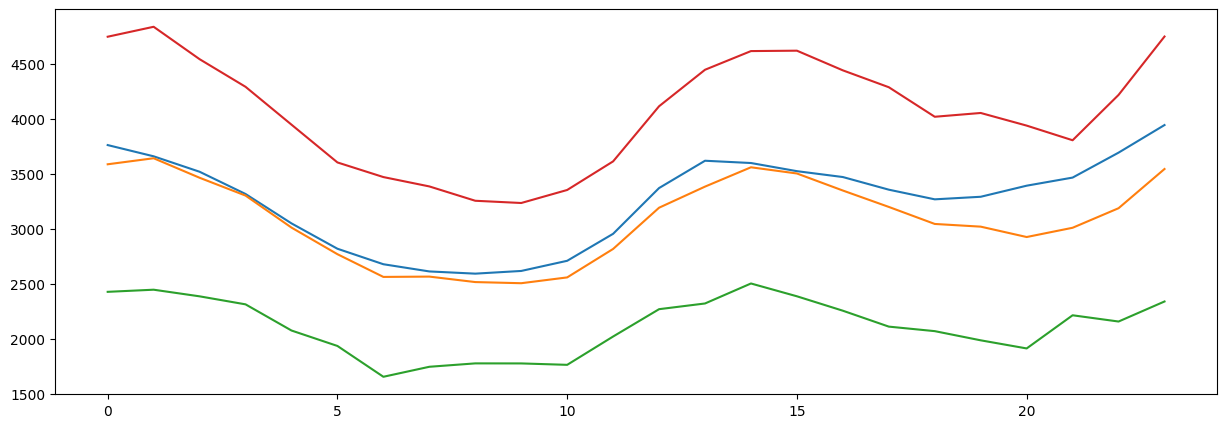

In [7]:
test_actual['1/1/2020 18:00-1/2/2020 17:00'].plot(figsize=(15, 5))
test_predicted['1/1/2020 18:00-1/2/2020 17:00'].plot(figsize=(15, 5))
(test_predicted['1/1/2020 18:00-1/2/2020 17:00']-1.96*test_std['1/1/2020 18:00-1/2/2020 17:00']).plot(figsize=(15, 5))
(test_predicted['1/1/2020 18:00-1/2/2020 17:00']+1.96*test_std['1/1/2020 18:00-1/2/2020 17:00']).plot(figsize=(15, 5))
plt.show()

# Scatterplots

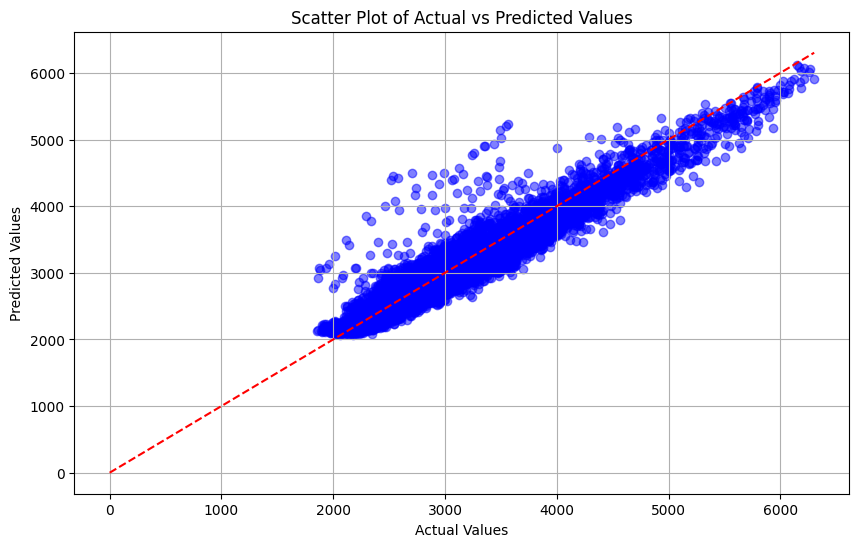

In [8]:
# Flatten the data from wide format (day columns) to long format (single series)
actual_values = test_actual.values.flatten()
predicted_values = test_predicted.values.flatten()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5, color='blue')

# Plot the line y=x for reference
max_value = max(actual_values.max(), predicted_values.max())
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--')

# Add labels and title
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

# Confidence Intervals

## 5/95%

In [9]:
total_values = 0
exceedance_count = 0

# Loop through each day (column)
for day in test_actual.columns:
    actual_values = test_actual[day]
    predicted_values = test_predicted[day]
    std_values = test_std[day]

    # Calculate the lower and upper bounds of the 95% confidence interval
    lower_bound = predicted_values - 1.96 * std_values
    upper_bound = predicted_values + 1.96 * std_values

    # Check if actual values fall within the confidence interval
    exceedance = (actual_values < lower_bound) | (actual_values > upper_bound)

    # Update counters
    total_values += len(actual_values)
    exceedance_count += exceedance.sum()

# Calculate exceedance probability
exceedance_probability = exceedance_count / total_values * 100

print(f"Exceedance Probability: {exceedance_probability:.2f}%")

Exceedance Probability: 0.18%


## 10/90%

In [10]:
# 10/90
total_values = 0
exceedance_count = 0

# Loop through each day (column)
for day in test_actual.columns:
    actual_values = test_actual[day]
    predicted_values = test_predicted[day]
    std_values = test_std[day]

    # Calculate the lower and upper bounds of the 95% confidence interval
    lower_bound = predicted_values - 1.28 * std_values
    upper_bound = predicted_values + 1.28 * std_values

    # Check if actual values fall within the confidence interval
    exceedance = (actual_values < lower_bound) | (actual_values > upper_bound)

    # Update counters
    total_values += len(actual_values)
    exceedance_count += exceedance.sum()

# Calculate exceedance probability
exceedance_probability = exceedance_count / total_values * 100

print(f"Exceedance Probability: {exceedance_probability:.2f}%")

Exceedance Probability: 0.60%


## 25/75%

In [11]:
# 25/75
total_values = 0
exceedance_count = 0

# Loop through each day (column)
for day in test_actual.columns:
    actual_values = test_actual[day]
    predicted_values = test_predicted[day]
    std_values = test_std[day]

    # Calculate the lower and upper bounds of the 95% confidence interval
    lower_bound = predicted_values - 0.67 * std_values
    upper_bound = predicted_values + 0.67 * std_values

    # Check if actual values fall within the confidence interval
    exceedance = (actual_values < lower_bound) | (actual_values > upper_bound)

    # Update counters
    total_values += len(actual_values)
    exceedance_count += exceedance.sum()

# Calculate exceedance probability
exceedance_probability = exceedance_count / total_values * 100

print(f"Exceedance Probability: {exceedance_probability:.2f}%")

Exceedance Probability: 7.11%


# All together now!

In [23]:
import pandas as pd
import plotly.graph_objects as go

def analyze_predictions(test_actual_path, test_predicted_path, test_std_path, month, year, ci_type="95"):
    # Load CSV files
    test_actual = pd.read_csv(test_actual_path, index_col=0)
    test_predicted = pd.read_csv(test_predicted_path, index_col=0)
    test_std = pd.read_csv(test_std_path, index_col=0)

    # Define the Z-values based on the desired confidence interval
    ci_z_values = {"95": 1.96, "25/75": 0.6745, "10/90": 1.2816}
    z_value = ci_z_values.get(ci_type, 1.96)  # Default to 95% CI

    # Extract date portion from column names and convert to datetime
    def extract_date_from_column(col_name):
        # Assuming the column name format is: "1/8/2019 0:00-1/8/2019 23:00"
        date_str = col_name.split()[0]  # Take the first part before the space (i.e., "1/8/2019")
        return pd.to_datetime(date_str, format='%m/%d/%Y')

    # Apply extraction to all column names
    date_columns = [extract_date_from_column(col) for col in test_actual.columns]

    # Filter by specified month and year
    filtered_indices = [i for i, date in enumerate(date_columns)
                        if date.month == int(month) and date.year == int(year)]

    selected_columns = [test_actual.columns[i] for i in filtered_indices]

    # Initialize counters for exceedance calculation
    total_values = 0
    exceedance_count = 0

    # Flatten data for scatterplot
    all_actual_values = []
    all_predicted_values = []

    # Loop through each day (filtered by month/year)
    for day in selected_columns:
        # Extracting data for the day and aligning indices
        actual_values = test_actual[day].reset_index(drop=True)
        predicted_values = test_predicted[day].reset_index(drop=True)
        std_values = test_std[day].reset_index(drop=True)

        # Calculate the confidence interval bounds
        lower_bound = predicted_values - z_value * std_values
        upper_bound = predicted_values + z_value * std_values

        # Check if actual values fall within the confidence interval
        exceedance = (actual_values < lower_bound) | (actual_values > upper_bound)
        total_values += len(actual_values)
        exceedance_count += exceedance.sum()

        # Collect data for scatterplot
        all_actual_values.extend(actual_values.values)
        all_predicted_values.extend(predicted_values.values)

        # Daily time series plot using Plotly
        fig = go.Figure()
        fig.add_trace(go.Scatter(y=actual_values, mode='lines', name='Actual', line=dict(color='blue')))
        fig.add_trace(go.Scatter(y=predicted_values, mode='lines', name='Predicted', line=dict(color='orange')))
        fig.add_trace(go.Scatter(y=lower_bound, mode='lines', name='Lower Bound (CI)', line=dict(dash='dash', color='green')))
        fig.add_trace(go.Scatter(y=upper_bound, mode='lines', name='Upper Bound (CI)', line=dict(dash='dash', color='red')))

        fig.update_layout(
            title=f"Time Series Plot for {day}",
            xaxis_title="Hour",
            yaxis_title="Values",
            legend_title="Legend",
            template="plotly_white"
        )
        fig.show()

    # Calculate exceedance probability
    exceedance_probability = exceedance_count / total_values * 100
    print(f"Exceedance Probability for {month}/{year} ({ci_type} CI): {exceedance_probability:.2f}%")

    # Scatter plot of actual vs. predicted values using Plotly
    scatter_fig = go.Figure()
    scatter_fig.add_trace(go.Scatter(x=all_actual_values, y=all_predicted_values, mode='markers', 
                                     name='Data Points', marker=dict(color='blue', opacity=0.5)))
    max_value = max(max(all_actual_values), max(all_predicted_values))
    scatter_fig.add_trace(go.Scatter(x=[0, max_value], y=[0, max_value], mode='lines', 
                                     name='y=x', line=dict(color='red', dash='dash')))

    scatter_fig.update_layout(
        title=f"Scatter Plot of Actual vs Predicted Values for {month}/{year}",
        xaxis_title="Actual Values",
        yaxis_title="Predicted Values",
        template="plotly_white",
        legend_title="Legend"
    )
    scatter_fig.show()

    return exceedance_probability

# Example usage
test_actual_path = '/home/jik19004/FilesToRun/BayesianBiDirectional/TestingLong/TestingActual_long.csv'
test_predicted_path = '/home/jik19004/FilesToRun/BayesianBiDirectional/TestingLong/TestingPredictionsLong.csv'
test_std_path = '/home/jik19004/FilesToRun/BayesianBiDirectional/TestingLong/TestingStdLong.csv'
month = "1"  # September
year = "2021"
ci_type = "95"  # Confidence interval type: "95", "25/75", or "10/90"

# Call the function
exceedance_prob = analyze_predictions(test_actual_path, test_predicted_path, test_std_path, month, year, ci_type)


Exceedance Probability for 1/2021 (95 CI): 0.00%


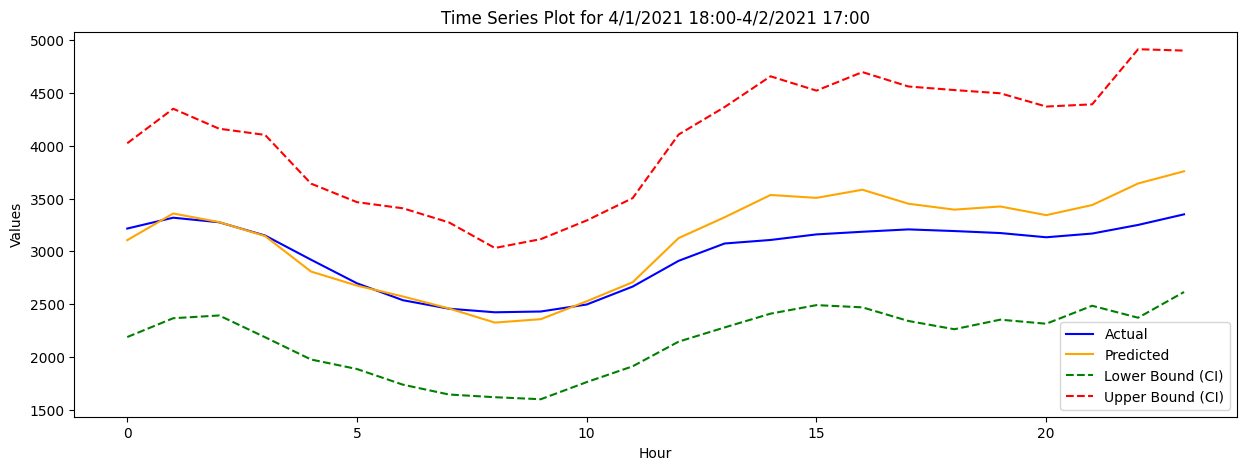

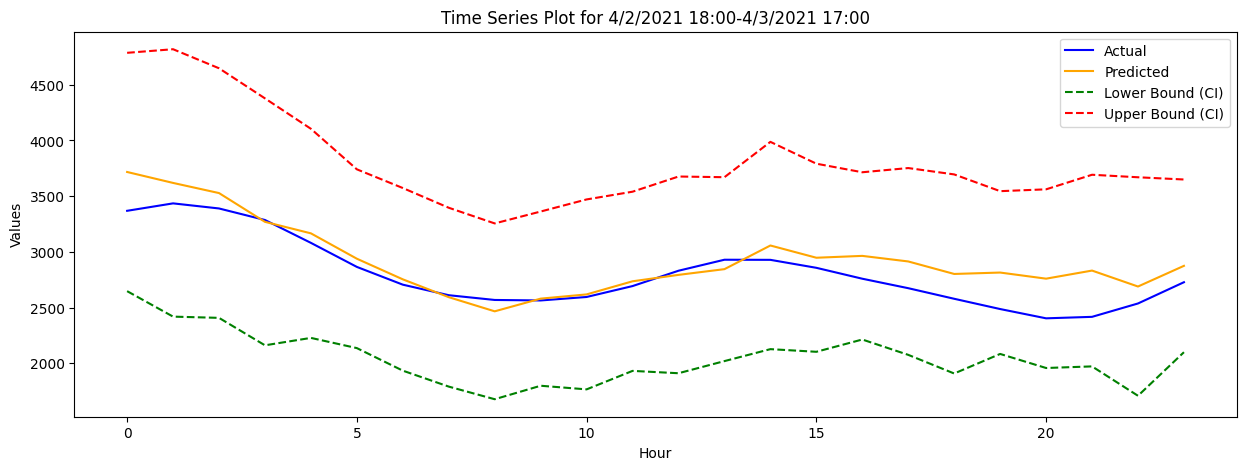

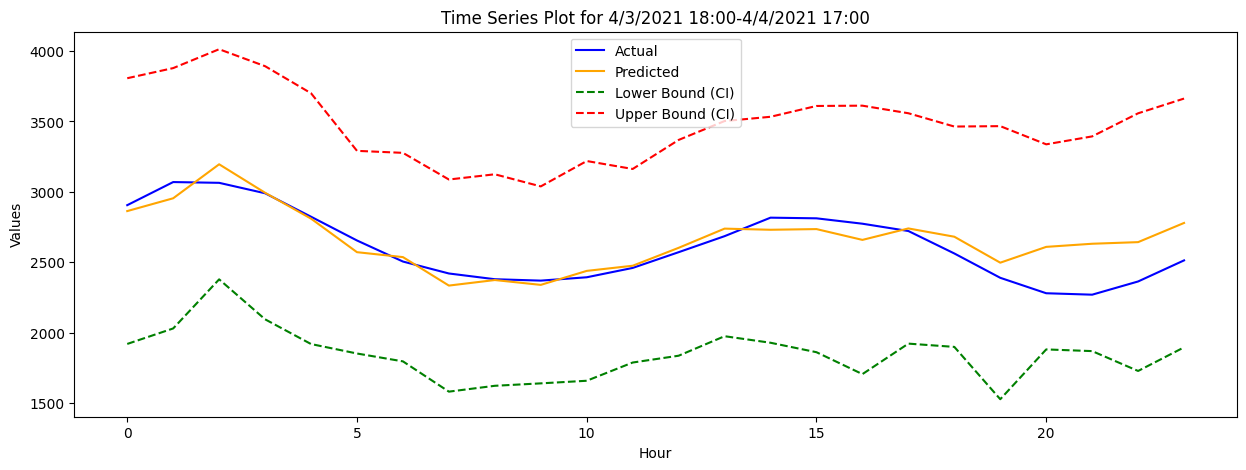

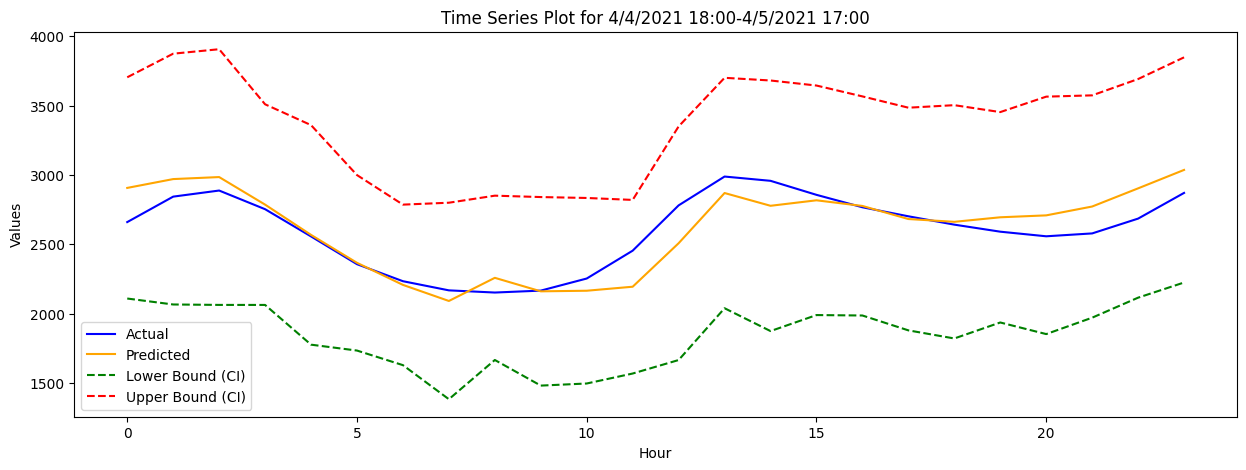

KeyboardInterrupt: 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Function to analyze and visualize data for a given month/year
def analyze_predictions(test_actual_path, test_predicted_path, test_std_path, month, year, ci_type="95"):
    # Load CSV files
    test_actual = pd.read_csv(test_actual_path, index_col=0)
    test_predicted = pd.read_csv(test_predicted_path, index_col=0)
    test_std = pd.read_csv(test_std_path, index_col=0)

    # Define the Z-values based on the desired confidence interval
    ci_z_values = {"95": 1.96, "25/75": 0.6745, "10/90": 1.2816}
    z_value = ci_z_values.get(ci_type, 1.96)  # Default to 95% CI

    # Extract date portion from column names and convert to datetime
    def extract_date_from_column(col_name):
        # Assuming the column name format is: "1/8/2019 0:00-1/8/2019 23:00"
        date_str = col_name.split()[0]  # Take the first part before the space (i.e., "1/8/2019")
        return pd.to_datetime(date_str, format='%m/%d/%Y')

    # Apply extraction to all column names
    date_columns = [extract_date_from_column(col) for col in test_actual.columns]

    # Filter by specified month and year
    filtered_indices = [i for i, date in enumerate(date_columns)
                        if date.month == int(month) and date.year == int(year)]

    selected_columns = [test_actual.columns[i] for i in filtered_indices]

    # Initialize counters for exceedance calculation
    total_values = 0
    exceedance_count = 0

    # Flatten data for scatterplot
    all_actual_values = []
    all_predicted_values = []

    # Loop through each day (filtered by month/year)
    for day in selected_columns:
        # Extracting data for the day and aligning indices
        actual_values = test_actual[day].reset_index(drop=True)
        predicted_values = test_predicted[day].reset_index(drop=True)
        std_values = test_std[day].reset_index(drop=True)

        # Calculate the confidence interval bounds
        lower_bound = predicted_values - z_value * std_values
        upper_bound = predicted_values + z_value * std_values

        # Check if actual values fall within the confidence interval
        exceedance = (actual_values < lower_bound) | (actual_values > upper_bound)
        total_values += len(actual_values)
        exceedance_count += exceedance.sum()

        # Collect data for scatterplot
        all_actual_values.extend(actual_values.values)
        all_predicted_values.extend(predicted_values.values)

        # Daily time series plot
        plt.figure(figsize=(15, 5))
        actual_values.plot(label='Actual', color='blue')
        predicted_values.plot(label='Predicted', color='orange')
        lower_bound.plot(label='Lower Bound (CI)', linestyle='--', color='green')
        upper_bound.plot(label='Upper Bound (CI)', linestyle='--', color='red')
        plt.title(f"Time Series Plot for {day}")
        plt.xlabel("Hour")
        plt.ylabel("Values")
        plt.legend()
        plt.show()

    # Calculate exceedance probability
    exceedance_probability = exceedance_count / total_values * 100
    print(f"Exceedance Probability for {month}/{year} ({ci_type} CI): {exceedance_probability:.2f}%")

    # Scatter plot of actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(all_actual_values, all_predicted_values, alpha=0.5, color='blue')
    max_value = max(max(all_actual_values), max(all_predicted_values))
    plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', label="y=x")
    plt.title(f"Scatter Plot of Actual vs Predicted Values for {month}/{year}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid()
    plt.legend()
    plt.show()

    return exceedance_probability

# Example usage
test_actual_path = '/home/jik19004/FilesToRun/BayesianBiDirectional/TestingLong/TestingActual_long.csv'
test_predicted_path = '/home/jik19004/FilesToRun/BayesianBiDirectional/TestingLong/TestingPredictionsLong.csv'
test_std_path = '/home/jik19004/FilesToRun/BayesianBiDirectional/TestingLong/TestingStdLong.csv'
month = "4"     # January
year = "2021"
ci_type = "95"  # Confidence interval type: "95", "25/75", or "10/90"

# Call the function
exceedance_prob = analyze_predictions(test_actual_path, test_predicted_path, test_std_path, month, year, ci_type)
